In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import math
import random
import mpltern
from PIL import Image

In [2]:
#Random Number Generator
rng = np.random.default_rng()

## Framework for Simulations

In [3]:
class Player:
    def __init__(self, actions:int = 0, strategy:np.ndarray = np.empty((0,), dtype=np.float32), size:float = 1, speed:float = 1, fitness:float = 1) -> None:
        self.pastPayoffs = np.empty(shape=(0,))
        self.actions = actions
        assert(strategy.ndim == 1)
        assert(strategy.shape[0] == actions)
        self.strategy = strategy
        if(np.sum(strategy) != 1):
            self.strategy /= max(1., np.sum(strategy))
        self.size = size
        self.speed = speed
        self.fitness = fitness

    def GetAction(self) -> int:
        return rng.choice(self.actions, size=1, p=self.strategy)

    def ExtendPayoffs(self, newPayoffs: np.ndarray) -> None:
        self.pastPayoffs = np.concatenate([self.pastPayoffs, newPayoffs])

    def GetPayoff(self) -> np.ndarray:
        return self.pastPayoffs
    
    def SetSpeed(self, speed:float) -> None:
        self.speed = speed
    
    def SetSize(self, size:float) -> None:
        self.size = size

    def UpdateSpeed(self, delSpeed:float) -> None:
        self.speed += delSpeed

    def UpdateSize(self, delSize:float) -> None:
        self.size += delSize

    def SetFitness(self, fitness: float) -> None:
        self.fitness = fitness
    
    def UpdateFitness(self, delFit: float) -> None:
        self.fitness *= (1+delFit)
        self.fitness = max(self.fitness, 1e-7)


In [4]:
class Game:
    """ 
    utility: np.ndarray with dimensions nPlayers+1 and shape[i]=player[i].actions and shape[-1]=nPlayers
    """
    def __init__(self, nPlayers:int, strategies:list[np.ndarray], utility:np.ndarray):
        assert(len(strategies) == nPlayers)
        maxActions=0;
        for i in range(nPlayers):
            assert(utility.shape[i] == strategies[i].size)
            maxActions = max(maxActions, strategies[i].size)
        assert(utility.shape[-1] == nPlayers)
        self.Players = [Player(strategies[i].size, strategies[i]) for i in range(nPlayers)]
        self.utility = utility.astype(np.float32)
        strategylengths = [strategies[i].size for i in range(nPlayers)]
        self.tiledProbability = np.ones(shape = [nPlayers, *strategylengths])
        self.allPayoffs = np.empty(shape = [nPlayers, 0])
        self.newPayoffs = np.empty(shape = [nPlayers, 0])
        for i in range(nPlayers):
            x = np.reshape(strategies[i], [1 if j!=i else -1 for j in range(nPlayers)])
            self.tiledProbability[i] *= x

        self.probability = np.prod(self.tiledProbability, axis=0)


    """
    returns payoff of ith player if 0<=i<nPlayers
    return an array of payoff of all players otherwise
    """
    def GetExpectedPayoff(self, i:int) -> np.ndarray:
        u = self.utility.copy()
        u *= np.expand_dims(self.probability, axis=-1)
        payoff=np.sum(u, axis=tuple(range(len(self.Players))))
        if(0<=i and i<len(self.Players)):
            return np.round(payoff[i], 8)
        else:
            return payoff
        
    def GetRandomStrategyProfile(self):
        flat_prob = self.probability.flatten()
        flat_ind = np.random.choice(len(flat_prob), p=flat_prob)
        return np.unravel_index(flat_ind, self.probability.shape)
    
    def GetPayoff(self, actions:tuple, i:int):
        p = self.utility[actions]
        if(0<=i and i<len(self.Players)):
            return p[i]
        else:
            return p

    def PlayGame(self):
        strategyProfile = self.GetRandomStrategyProfile()
        payoffs = self.GetPayoff(strategyProfile, -1)
        payoffs2 = payoffs.reshape((-1,1))
        self.newPayoffs = np.hstack([self.newPayoffs,payoffs2] )
        return payoffs
    
    def GetPayoffForPlayerStrategy(self, player:int, strategy:np.ndarray) -> np.ndarray:
        if(np.sum(strategy) != 1 or strategy.shape != (self.Players[player].actions,)):
            raise ValueError("Not a valid strategy")
        x = np.reshape(strategy, [1 if j!=player else -1 for j in range(len(self.Players))])
        y = self.tiledProbability.copy()
        y[player]=x
        prob = np.prod(y, axis=0)
        u = self.utility.copy()
        u *= np.expand_dims(prob, axis=-1)
        payoff=np.sum(u, axis=tuple(range(len(self.Players))))
        return payoff
    def GetPayoffForStrategy(self, strategy:list[np.ndarray]) -> np.ndarray:
        probability = np.ones(shape = [len(strategy[i]) for i in range(len(strategy))])
        for i in range(len(strategy)):
            x = strategy[i].reshape([1 if i!=j else -1 for j in range(len(strategy))])
            probability *= x
        u = self.utility.copy()
        u = self.utility.copy()
        u *= np.expand_dims(probability, axis=-1)
        payoff=np.sum(u, axis=tuple(range(len(self.Players))))
        return payoff



    def GetPastPayoffs(self, player:int) -> np.ndarray:
        if(self.newPayoffs.size>0):
            for i in range(len(self.Players)):
                self.Players[i].ExtendPayoffs(self.newPayoffs[i])
        self.allPayoffs = np.hstack([self.allPayoffs, self.newPayoffs])
        self.newPayoffs = np.empty(shape=(len(self.Players),0))
        if(0<=player and player<len(self.Players)):
            return self.Players[player].GetPayoff()
        else:
            return self.allPayoffs
            


        

## Chemostat Simulation

### Simulation Variables

In [64]:
populationSize = 200
fitnessChange = 0.02
fitnessIncChance = 0.02
fitnessDecChance = 0.0201
generations = 500
parallelSimulations = 10

### Basic Chemostat

The following function simulates a chemostat with the parameters provided and returns the fitness data of all generations.

In [65]:
def BasicChemostat(**kwargs) -> np.ndarray:
    fitnessData = np.empty(dtype = np.float64, shape=(0,generations,populationSize))
    fitnessIncreaseCount = 0
    fitnessDecreaseCount = 0
    higherFitChosenCount = 0
    lowerFitChosenCount = 0
    for sim in range(1,parallelSimulations+1):
        population = [Player(fitness=1) for i in range(populationSize)]
        fitnesses = np.asarray([p.fitness for p in population], dtype=np.float64)
        probabilities = fitnesses / np.sum(fitnesses)
        simFitness = np.empty(dtype = np.float64, shape=(0, populationSize))
        avgFitness = np.mean(fitnesses)

        for i in range(1,generations+1):
            rnd = rng.random(size=(populationSize,))
            parents = rng.choice(range(populationSize), (populationSize,), p=probabilities)
            currentPopulation = population
            population = []
            for idx,j in enumerate(parents):
                if(currentPopulation[j].fitness > avgFitness*1.01):
                    higherFitChosenCount += 1
                elif(currentPopulation[j].fitness <= avgFitness*0.99):
                    lowerFitChosenCount += 1
                population.append(Player(size=currentPopulation[j].size, speed = currentPopulation[j].speed, fitness=currentPopulation[j].fitness))
                if(rnd[j]<fitnessIncChance):
                    population[-1].UpdateFitness(fitnessChange)
                    fitnessIncreaseCount += 1
                elif(rnd[j]<fitnessIncChance+fitnessDecChance):
                    population[-1].UpdateFitness(-fitnessChange)
                    fitnessDecreaseCount += 1
                fitnesses[idx] = population[-1].fitness

            probabilities = fitnesses / np.sum(fitnesses)
            avgFitness = np.mean(fitnesses)
            simFitness = np.concatenate([simFitness, np.reshape(fitnesses, (1,-1))],axis=0)
        fitnessData = np.concatenate([fitnessData, np.reshape(simFitness, (1,generations, populationSize))], axis=0)
    return fitnessData
    


In [67]:
fitnessData = BasicChemostat(
    populationSize = populationSize,
    fitnessChange = fitnessChange,
    fitnessIncChance = fitnessIncChance,
    fitnessDecChance = fitnessDecChance,
    generations = generations,
    parallelSimulations = parallelSimulations
)

In [66]:
def FindRate(data: np.ndarray,offset:int) -> float:
    x = np.arange(offset,len(data),1,dtype=np.float32)
    y = np.log(data[offset:])
    n = len(x)
    #this should be linear
    #rate is the slope of this line
    m = (n*np.sum(x*y)-np.sum(x)*np.sum(y))/(n*np.sum(x**2)-(np.sum(x))**2)
    c = (np.sum(y) - m*np.sum(x)) / n
    return m,c



### Visualise

In [68]:
sortedFitnessData = np.sort(fitnessData)
avgAcrossSims = np.mean(sortedFitnessData, axis=0)
avgFitnessforGen = np.mean(fitnessData, axis=-1)
averageFitness = np.mean(avgFitnessforGen, axis=0)

In the following cell, we plot _number of organisms_ vs _fitness_ for different generations. We can observe the travelling wave model

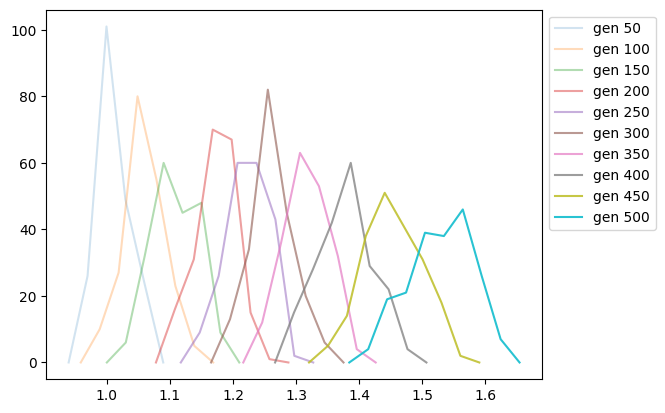

In [114]:
binWidth = 0.03

for i in range(10):
    data = avgAcrossSims[int((i+1)*(generations/10)-1)]
    n,bins= np.histogram(data, bins = np.arange(np.min(data)-binWidth, np.max(data)+2*binWidth,binWidth))
    bincentres = 0.5*(bins[1:]+bins[:-1])
    plt.plot(bincentres, n, label=f"gen {int((i+1)*generations/10)}", alpha = (50+20*i)/250)
plt.legend(bbox_to_anchor=(1, 1))

plt.savefig("plots/wave.png")
plt.show()

Here, we plot _average fitness for each simulation_ vs _generation_ 
We also plot average fitness across simulations.  

We approximate average fitness as 
$ f_{av} = \exp{(m \cdot \text{gen} + c)} $



rate = 0.0008806494713550324
intercept = -0.024822877824413857
average_c = exp(rate*gen+intercept)


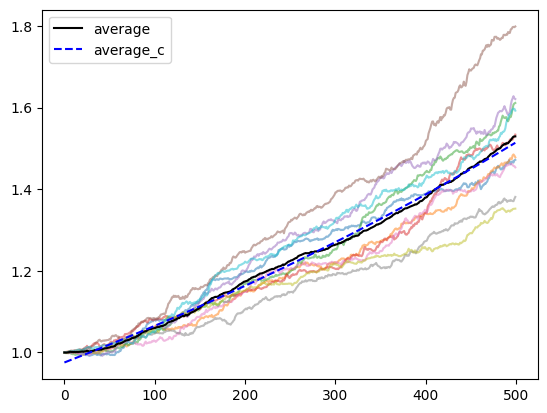

In [115]:
for i in range(parallelSimulations):
    data = avgFitnessforGen[i]
    plt.plot(data, alpha=0.5)

x = np.arange(0,generations,1)
rate, intercept = FindRate(averageFitness,100)

print(f"rate = {rate}\nintercept = {intercept}")
print("average_c = exp(rate*gen+intercept)")

y = np.exp(rate*x+intercept)

plt.plot(averageFitness, color=(0,0,0), label="average")
plt.plot(x,y,'--',color='b', label="average_c")

plt.legend()
plt.savefig("plots/avgFitness.png")
plt.show()


### Simulation

Here, we try to find out the relation between rate of evolution and population

In [ ]:
pop = [i*100 for i in range(1,31)]
fitnessChanges = [0.01, 0.005, 0.0025, 0.001]
rate = []
intercept = []
averageData = np.empty(shape=(0,generations))

for idx,fit in enumerate(fitnessChanges):
	rate = []
	intercept = []
	for i,p in enumerate(pop):
		print(f"p = {p}")
		population = p
		fitnessChange = fit
		fitnessData = BasicChemostat(
			populationSize = populationSize,
			fitnessChange = fitnessChange,
			fitnessIncChance = fitnessIncChance,
			fitnessDecChance = fitnessDecChance,
			generations = generations,
			parallelSimulations = parallelSimulations
		)
		avgFitnessforGen = np.mean(fitnessData, axis=-1)
		averageFitness = np.mean(avgFitnessforGen, axis=0)
		m,c = FindRate(averageFitness, int(generations/2))
		rate.append(m)
		intercept.append(c)
		print(f"\tm = {m}\n\tc = {c}")
		averageData = np.concatenate([averageData, np.reshape(averageFitness, (1,-1))], axis=0)
	np.savetxt(f"rate/rate{idx}.txt", np.asarray(rate))


In [ ]:
#rate = np.loadtxt("rate.txt")

#for txt files prefixed with simulation variables
file = open("rate0.txt", "r")
rate = []
for l in file:
    if(l[0]=='#'):
        continue
    else:
        x = float(l)
        rate.append(x)
rate = np.asarray(rate)
file.close()
        

In [ ]:
files =[fn for fn in os.listdir("rate/") if(re.match("^rate[0-9]*\.txt",fn)) ]

rateData = np.empty((0,30))
FitnessChangeList = []

for fn in files:
	file = open("rate/"+fn, "r")
	rate_ = []
	currFit = 0
	for l in file:
		if(l[0]=='#'):
			l = l.split()
			if(l[0]=="#fitnessChange"):
				currFit = float(l[2])
		else:
			x = float(l)
			rate_.append(x)
	FitnessChangeList.append(currFit)
	rate_ = np.reshape(np.asarray(rate_), (1,-1))
	rateData = np.concatenate([rateData, rate_])
	file.close()


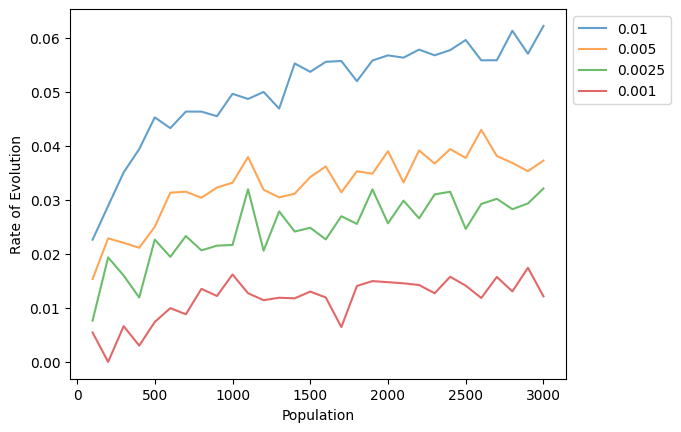

<Figure size 640x480 with 0 Axes>

In [116]:
for i in range(len(rateData)):
	plt.plot(pop, rateData[i] / FitnessChangeList[i]  , label = FitnessChangeList[i], alpha = 0.7 )

#plt.plot(rate)

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Population")
plt.ylabel("Rate of Evolution")
plt.show()

plt.savefig("plots/ratevpop.png")

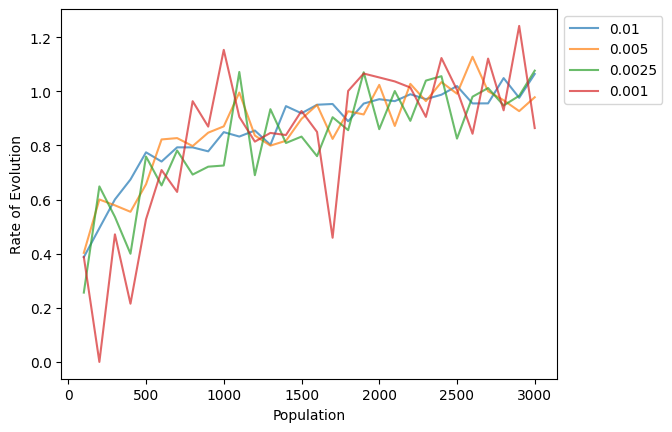

<Figure size 640x480 with 0 Axes>

In [117]:
for i in range(len(rateData)):
	plt.plot(pop, rateData[i] / np.mean(rateData[i, -5:])  , label = FitnessChangeList[i], alpha = 0.7 )

#plt.plot(rate)

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Population")
plt.ylabel("Rate of Evolution")
plt.show()
plt.savefig("plots/ratevpop1.png")

#### Conclusion

The above plots show that with an increase in population, rate of evolution also increases. A possible explanation for this is that with a lower population, a lower number of indivduals with a higher fitness are present, and it is harder for them to overcome the whole population. 

The second plot shows the relative increase in rate of evolution with increase in population. We can observe that the relative increase in rate of evolution is more or less independent of fitnessChange.

## Rock Paper Scissors

Consider a species with three kinds of organisms. We name them 'Rocks', 'Papers' and 'Scissors'. We observe that Rocks perform better than Scissors, Scissors perform better that Papers and Papers perform better than Rocks. So, we study how the population of such a species evolves.

In [5]:
class Simulation:
	def __init__(self, rock: int, paper: int, scissor: int, win = 1.5, draw = 0.7, loss = 0.5, mutationChance = 0.0, mutationRate = 0.0):
		self.rock=rock
		self.paper=paper
		self.scissor=scissor
		self.population = []
		self.generations=0
		for i in range(rock):
			self.population.append(Player(3, np.asarray([0.9,0.05,0.05]),fitness=0))
		for i in range(paper):
			self.population.append(Player(3, np.asarray([0.05,0.9,0.05]),fitness=0))
		for i in range(scissor):
			self.population.append(Player(3, np.asarray([0.05,0.05,0.9]),fitness=0))
		random.shuffle(self.population)
		self.payoff=np.asarray([
			[draw, loss, win ],
			[win , draw, loss],
			[loss, win , draw]
		])
		self.history = np.empty(shape=(0,4))
		self.mutationChance = mutationChance
		self.mutationRate = mutationRate

	def simulate(self, generations: int, minPopulation: int, plot = False, plotDir=""):
		for i in range(self.generations,self.generations+generations):
			print(f"Generation {i+1}")
			newPopulation = []
			if(len(self.population) <= minPopulation):
				for k in range(min(minPopulation - len(self.population), len(self.population))):
					self.population[k].fitness = 2
			for j in range(0,len(self.population),2):
				while(j < len(self.population) and self.population[j].fitness != 0):
					j += 1
				if(j+1>=len(self.population)):
					break
				action1 = self.population[j].GetAction()
				action2 = self.population[j+1].GetAction()
				self.population[j].fitness = float(self.payoff[action1,action2])
				self.population[j+1].fitness = float(self.payoff[action2,action1])
			for p in self.population:
				strategy = p.strategy
				for k in range(int(p.fitness)):
					newPopulation.append(Player(p.actions, p.strategy, fitness=0))
				chance = p.fitness-int(p.fitness)
				if(chance > 0 and random.random() < chance):
						newPopulation.append(Player(p.actions, p.strategy, fitness=0))
			if(self.mutationChance > 0):
				for p in newPopulation:
					r = random.random()
					if(r < self.mutationChance):
						r2 = random.randint(0,2)
						p.strategy[r2]+=self.mutationRate
					p.strategy = p.strategy / np.sum(p.strategy)
			self.population = newPopulation
			random.shuffle(self.population)
			del newPopulation
			count = [0,0,0,0]
			for p in self.population:
				p1 = np.roll(p.strategy, 1)
				p2 = np.roll(p.strategy, 2)
				x = np.abs(p.strategy-p1)
				y = np.abs(p.strategy-p2)
				if(max(np.max(x),np.max(y)) < 0.2):
					count[3]+=1
				else:
					count[np.argmax(p.strategy)]+=1
			self.history = np.concatenate([self.history, np.reshape(count, (1,-1))])
			if(plot):
				stratHistory = np.empty(shape=(0,3))
				fig = plt.figure(figsize=(8, 8))
				tern = plt.subplot(1,1,1,projection='ternary')
				for p in self.population:
					stratHistory = np.concatenate([stratHistory, np.reshape(p.strategy, (1,-1))])
				r=stratHistory[:,0]
				p=stratHistory[:,1]
				s=stratHistory[:,2]
				plot = tern.hexbin(r,p,s, gridsize=15)
				cbar = fig.colorbar(plot, anchor=(1,1))
				plt.title(f"Generation {i+1}")

				tern.set_tlabel("Rock")
				tern.set_llabel("Paper")
				tern.set_rlabel("Scissors")

				plt.savefig(plotDir + f"/gen{i+1}.png")
				plt.close(fig)


			print(f"\trock     : {count[0]}\n\tpaper    : {count[1]}\n\tscissors : {count[2]}")
		self.generations += generations

		


### Dominance by One Strategy

We define the following payoff matrix: 

| -			| Rock | Paper | Scissor 	|
| ---	 	| ---	| --- 	| ---		|
| **Rock** 	| 1	| 0.5 	| 1.5		|
|**Paper** 	| 1.5	| 1 	| 0.5		|
|**Scissor**| 0.5  | 1.5 	| 1			|


In [109]:
sim = Simulation(100, 100, 100, 1.5, 1, 0.5)
sim.simulate(120, 150)

Generation 1
	rock     : 107
	paper    : 97
	scissors : 95
Generation 2
	rock     : 109
	paper    : 103
	scissors : 93
Generation 3
	rock     : 97
	paper    : 108
	scissors : 90
Generation 4
	rock     : 94
	paper    : 112
	scissors : 96
Generation 5
	rock     : 96
	paper    : 107
	scissors : 97
Generation 6
	rock     : 104
	paper    : 102
	scissors : 92
Generation 7
	rock     : 90
	paper    : 91
	scissors : 82
Generation 8
	rock     : 79
	paper    : 99
	scissors : 79
Generation 9


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6632\2043289374.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.population[j].fitness = float(self.payoff[action1,action2])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6632\2043289374.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.population[j+1].fitness = float(self.payoff[action2,action1])


	rock     : 81
	paper    : 101
	scissors : 72
Generation 10
	rock     : 77
	paper    : 112
	scissors : 76
Generation 11
	rock     : 77
	paper    : 115
	scissors : 72
Generation 12
	rock     : 78
	paper    : 110
	scissors : 77
Generation 13
	rock     : 70
	paper    : 110
	scissors : 84
Generation 14
	rock     : 63
	paper    : 113
	scissors : 88
Generation 15
	rock     : 57
	paper    : 115
	scissors : 87
Generation 16
	rock     : 52
	paper    : 101
	scissors : 96
Generation 17
	rock     : 57
	paper    : 98
	scissors : 107
Generation 18
	rock     : 52
	paper    : 91
	scissors : 115
Generation 19
	rock     : 54
	paper    : 92
	scissors : 118
Generation 20
	rock     : 53
	paper    : 85
	scissors : 126
Generation 21
	rock     : 51
	paper    : 70
	scissors : 128
Generation 22
	rock     : 52
	paper    : 68
	scissors : 125
Generation 23
	rock     : 54
	paper    : 65
	scissors : 125
Generation 24
	rock     : 58
	paper    : 60
	scissors : 121
Generation 25
	rock     : 66
	paper    : 55
	scissors 

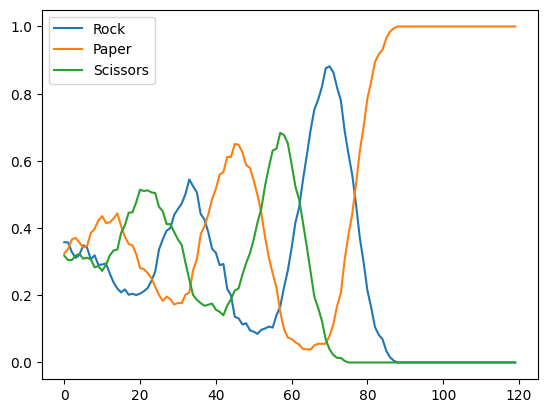

In [112]:
plt.plot(sim.history[:,0], label="Rock")
plt.plot(sim.history[:,1], label="Paper")
plt.plot(sim.history[:,2], label="Scissors")

plt.savefig("plots/dom.png")
plt.legend()

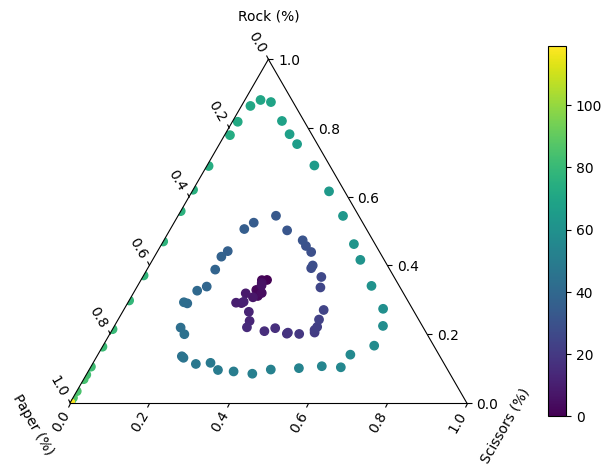

In [113]:
history = sim.history
sum = np.maximum(np.reshape(np.sum(history, axis = -1), (-1,1)), 1)
history /= sum

fig = plt.figure()
tern = plt.subplot(projection="ternary")
r,p,s = history[:,0],history[:,1],history[:,2]
plot = tern.scatter(r,p,s, c = range(len(r)), cmap="viridis")

tern.set_tlabel("Rock (%)")
tern.set_llabel("Paper (%)")
tern.set_rlabel("Scissors (%)")

cbar = fig.colorbar(plot, anchor = (1,1))

plt.savefig("plots/dom2.png")
plt.show()


Here we find that one of the strategies dominates over the others. Through multiple runs of the experiment, we find that no particular strategy dominates, and the finally emergent strategy is purely random.

### Equilibrium

Here, we apply a penalty for draws. In real life, this translates to the energy wasted by equally matched opponents on fighting. Now, the payoff matrix looks as 


| -			| Rock | Paper | Scissor 	|
| ---	 	| ---	| --- 	| ---		|
| **Rock** 	| 0.8	| 0.5 	| 1.5		|
|**Paper** 	| 1.5	| 0.8 	| 0.5		|
|**Scissor**| 0.5  | 1.5 	| 0.8		|

In [85]:
sim = Simulation(1200,600,200, 1.5, 0.8, 0.5)

In [86]:
sim.simulate(140, 1000)

Generation 1
	rock     : 973
	paper    : 678
	scissors : 178
Generation 2


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6632\2043289374.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.population[j].fitness = float(self.payoff[action1,action2])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6632\2043289374.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.population[j+1].fitness = float(self.payoff[action2,action1])


	rock     : 790
	paper    : 701
	scissors : 164
Generation 3
	rock     : 620
	paper    : 755
	scissors : 158
Generation 4
	rock     : 492
	paper    : 752
	scissors : 158
Generation 5
	rock     : 380
	paper    : 740
	scissors : 165
Generation 6
	rock     : 300
	paper    : 723
	scissors : 166
Generation 7
	rock     : 215
	paper    : 663
	scissors : 187
Generation 8
	rock     : 172
	paper    : 599
	scissors : 191
Generation 9
	rock     : 144
	paper    : 544
	scissors : 220
Generation 10
	rock     : 135
	paper    : 524
	scissors : 283
Generation 11
	rock     : 129
	paper    : 480
	scissors : 318
Generation 12
	rock     : 129
	paper    : 440
	scissors : 371
Generation 13
	rock     : 122
	paper    : 395
	scissors : 429
Generation 14
	rock     : 138
	paper    : 332
	scissors : 458
Generation 15
	rock     : 151
	paper    : 306
	scissors : 478
Generation 16
	rock     : 161
	paper    : 278
	scissors : 510
Generation 17
	rock     : 172
	paper    : 253
	scissors : 527
Generation 18
	rock     : 205

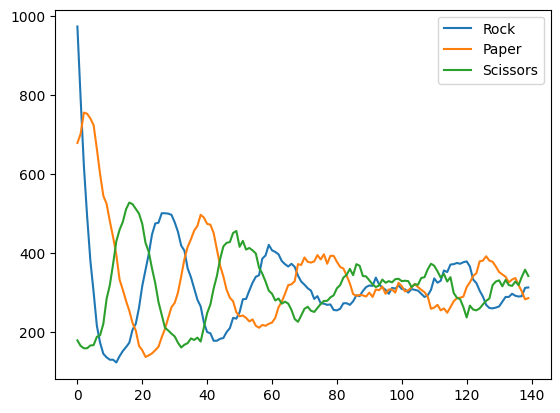

In [88]:
plt.plot(sim.history[:,0], label="Rock")
plt.plot(sim.history[:,1], label="Paper")
plt.plot(sim.history[:,2], label="Scissors")

plt.legend()
plt.savefig("plots/equilibrium1.png")
plt.show()

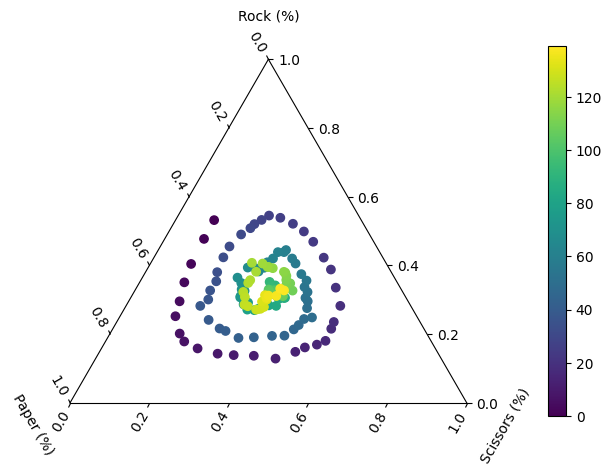

In [89]:
history = sim.history
sum = np.maximum(np.reshape(np.sum(history, axis = -1), (-1,1)), 1)
history /= sum

fig = plt.figure()
tern = plt.subplot(projection="ternary")
r,p,s = history[:,0],history[:,1],history[:,2]
plot = tern.scatter(r,p,s, c = range(len(r)), cmap="viridis")

tern.set_tlabel("Rock (%)")
tern.set_llabel("Paper (%)")
tern.set_rlabel("Scissors (%)")

cbar = fig.colorbar(plot, anchor = (1,1))
plt.savefig("equilibrium2.png")
plt.show()



Here, we observe that the population cycles about the point where all three strategies have an equal number of individuals. This is because if there are too many individuals of the same kind, they will compete with one another and since the payoff for draws is less than 1, their population decreases. The strategy wich beats this strategy will benefit from it and its numbers will increase. Hence we see a cycle Rock->Paper->Scissors.

### Mutation and Mixed Strategies

Here, we see what happens when individuals are allowed mixed strategies, i.e. each time, they randomly select an action. We also allow mutations which change the probabilities of selecting a certain action by a small amount.

In [77]:
sim = Simulation(1000,500,500, 1.4, 0.85, 0.4, 0.006, 0.1)

In [78]:
sim.simulate(2000, 1000,plot=True,plotDir="plots1")

Generation 1


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6632\2043289374.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.population[j].fitness = float(self.payoff[action1,action2])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6632\2043289374.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.population[j+1].fitness = float(self.payoff[action2,action1])


	rock     : 859
	paper    : 483
	scissors : 400
Generation 2
	rock     : 725
	paper    : 477
	scissors : 313
Generation 3
	rock     : 604
	paper    : 448
	scissors : 260
Generation 4
	rock     : 503
	paper    : 456
	scissors : 207
Generation 5
	rock     : 418
	paper    : 439
	scissors : 162
Generation 6
	rock     : 335
	paper    : 440
	scissors : 145
Generation 7
	rock     : 303
	paper    : 473
	scissors : 138
Generation 8
	rock     : 253
	paper    : 500
	scissors : 152
Generation 9
	rock     : 222
	paper    : 516
	scissors : 161
Generation 10
	rock     : 203
	paper    : 530
	scissors : 178
Generation 11
	rock     : 170
	paper    : 539
	scissors : 193
Generation 12
	rock     : 153
	paper    : 530
	scissors : 214
Generation 13
	rock     : 124
	paper    : 516
	scissors : 250
Generation 14
	rock     : 106
	paper    : 507
	scissors : 292
Generation 15
	rock     : 81
	paper    : 475
	scissors : 348
Generation 16
	rock     : 89
	paper    : 425
	scissors : 391
Generation 17
	rock     : 88
	pa

In [118]:
images = []

files = os.listdir("plots1")
p = re.compile("gen([0-9]*)\.png")
files = sorted(files, key=lambda f : int(p.search(f).group(1) ) )
for f in files:
    img = Image.open("plots1/"+f)
    images.append(img)
    

    
images[0].save("gifs/rps.gif",save_all = True, append_images=[*[images[0] for i in range(9)], *images, *[images[-1] for i in range(10)]], duration=50, loop=True)

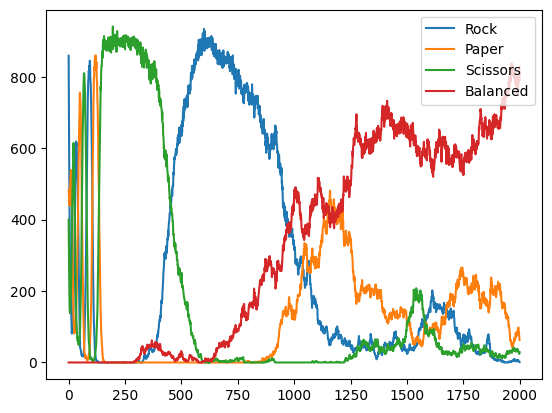

In [83]:
plt.plot(sim.history[:,0], label="Rock")
plt.plot(sim.history[:,1], label="Paper")
plt.plot(sim.history[:,2], label="Scissors")
plt.plot(sim.history[:,3], label="Balanced")

plt.legend()
plt.savefig("plots/mixed.png")

Following is the evolution of strategies of the population

<img src = "gifs/rps.gif">



Here, we observe that the the strategy of chosing Rock, Paper and Scissors an equal number of times slowly takes over. This is because it is a nash equilibrium. After this strategy has taken over, no other strategy can compete with this as any other strategy is guaranteed to have a worse outcome than this